<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S9/EVA4_S9_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Initialization

Import required modules

In [0]:
# !pip install albumentations==0.4.5

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from data.data_engine import DataEngine
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam

## Model Configuration and Set Seed

View model configuration and set the seed

In [2]:
# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 35,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


## Data Loading and Visualization

Preprocess and load the cifar10 dataset. Visualise the dataset.

Files already downloaded and verified
Files already downloaded and verified
plane   dog  deer  deer


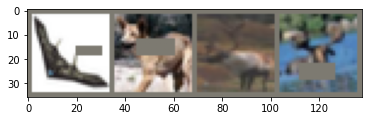

In [3]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

## Model

Create model and display model summary

In [4]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Training and Testing

Train the model and evaluate it

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=args.max_lr, epochs=args.epochs,
                       steps_per_epoch=len(data.train_loader))

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=458.94024658203125 L1_loss=109213.5078125 Loss=1.999307632446289 Batch_id=781 Accuracy=42.30: 100%|██████████| 782/782 [00:38<00:00, 20.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0195, Accuracy: 5514/10000 (55.14%)

EPOCH: 2


L2_loss=459.2803039550781 L1_loss=108979.0546875 Loss=2.5755016803741455 Batch_id=781 Accuracy=59.21: 100%|██████████| 782/782 [00:38<00:00, 20.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0152, Accuracy: 6696/10000 (66.96%)

EPOCH: 3


L2_loss=459.740478515625 L1_loss=108684.9375 Loss=1.6535159349441528 Batch_id=781 Accuracy=67.29: 100%|██████████| 782/782 [00:37<00:00, 20.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0134, Accuracy: 7055/10000 (70.55%)

EPOCH: 4


L2_loss=460.24249267578125 L1_loss=108301.8125 Loss=1.3823962211608887 Batch_id=781 Accuracy=71.97: 100%|██████████| 782/782 [00:37<00:00, 20.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0135, Accuracy: 7290/10000 (72.90%)

EPOCH: 5


L2_loss=460.7066955566406 L1_loss=107824.3984375 Loss=1.4558347463607788 Batch_id=781 Accuracy=75.48: 100%|██████████| 782/782 [00:37<00:00, 20.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0145, Accuracy: 7030/10000 (70.30%)

EPOCH: 6


L2_loss=461.2242431640625 L1_loss=107323.1640625 Loss=1.494114875793457 Batch_id=781 Accuracy=77.43: 100%|██████████| 782/782 [00:37<00:00, 20.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0100, Accuracy: 7887/10000 (78.87%)

EPOCH: 7


L2_loss=461.5077819824219 L1_loss=106735.78125 Loss=1.5704402923583984 Batch_id=781 Accuracy=79.68: 100%|██████████| 782/782 [00:37<00:00, 20.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0094, Accuracy: 8037/10000 (80.37%)

EPOCH: 8


L2_loss=461.72540283203125 L1_loss=106131.0390625 Loss=1.3427157402038574 Batch_id=781 Accuracy=81.16: 100%|██████████| 782/782 [00:37<00:00, 20.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0079, Accuracy: 8331/10000 (83.31%)

EPOCH: 9


L2_loss=461.5828857421875 L1_loss=105436.3671875 Loss=1.5797467231750488 Batch_id=781 Accuracy=82.72: 100%|██████████| 782/782 [00:37<00:00, 20.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8279/10000 (82.79%)

EPOCH: 10


L2_loss=461.3832092285156 L1_loss=104752.578125 Loss=1.137317419052124 Batch_id=781 Accuracy=84.07: 100%|██████████| 782/782 [00:37<00:00, 20.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0089, Accuracy: 8125/10000 (81.25%)

EPOCH: 11


L2_loss=461.00738525390625 L1_loss=104066.28125 Loss=1.018172264099121 Batch_id=781 Accuracy=85.27: 100%|██████████| 782/782 [00:37<00:00, 20.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8429/10000 (84.29%)

EPOCH: 12


L2_loss=460.5772705078125 L1_loss=103402.0 Loss=1.4609094858169556 Batch_id=781 Accuracy=86.23: 100%|██████████| 782/782 [00:37<00:00, 20.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 78 %
Accuracy of   car : 98 %
Accuracy of  bird : 90 %
Accuracy of   cat : 77 %
Accuracy of  deer : 90 %
Accuracy of   dog : 77 %
Accuracy of  frog : 86 %
Accuracy of horse : 88 %
Accuracy of  ship : 92 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0070, Accuracy: 8569/10000 (85.69%)

EPOCH: 13


L2_loss=459.99658203125 L1_loss=102739.25 Loss=1.5130858421325684 Batch_id=781 Accuracy=86.98: 100%|██████████| 782/782 [00:37<00:00, 20.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 74 %
Accuracy of   cat : 88 %
Accuracy of  deer : 92 %
Accuracy of   dog : 77 %
Accuracy of  frog : 88 %
Accuracy of horse : 85 %
Accuracy of  ship : 78 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0072, Accuracy: 8506/10000 (85.06%)

EPOCH: 14


L2_loss=459.29388427734375 L1_loss=102085.5859375 Loss=1.0119967460632324 Batch_id=781 Accuracy=87.91: 100%|██████████| 782/782 [00:37<00:00, 20.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 95 %
Accuracy of   cat : 75 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 71 %
Accuracy of horse : 89 %
Accuracy of  ship : 88 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0069, Accuracy: 8584/10000 (85.84%)

EPOCH: 15


L2_loss=458.590576171875 L1_loss=101440.9140625 Loss=0.85356205701828 Batch_id=781 Accuracy=88.43: 100%|██████████| 782/782 [00:37<00:00, 20.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 90 %
Accuracy of  bird : 75 %
Accuracy of   cat : 61 %
Accuracy of  deer : 89 %
Accuracy of   dog : 85 %
Accuracy of  frog : 96 %
Accuracy of horse : 98 %
Accuracy of  ship : 88 %
Accuracy of truck : 84 %

Test set: Average loss: 0.0071, Accuracy: 8591/10000 (85.91%)

EPOCH: 16


L2_loss=457.78509521484375 L1_loss=100806.8515625 Loss=1.598584771156311 Batch_id=781 Accuracy=89.42: 100%|██████████| 782/782 [00:37<00:00, 20.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 90 %
Accuracy of   cat : 68 %
Accuracy of  deer : 85 %
Accuracy of   dog : 85 %
Accuracy of  frog : 85 %
Accuracy of horse : 91 %
Accuracy of  ship : 89 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0059, Accuracy: 8746/10000 (87.46%)

EPOCH: 17


L2_loss=456.9194641113281 L1_loss=100176.2265625 Loss=1.1746528148651123 Batch_id=781 Accuracy=89.85: 100%|██████████| 782/782 [00:37<00:00, 20.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 86 %
Accuracy of   car : 98 %
Accuracy of  bird : 81 %
Accuracy of   cat : 58 %
Accuracy of  deer : 91 %
Accuracy of   dog : 89 %
Accuracy of  frog : 91 %
Accuracy of horse : 93 %
Accuracy of  ship : 88 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0075, Accuracy: 8587/10000 (85.87%)

EPOCH: 18


L2_loss=456.08837890625 L1_loss=99610.3671875 Loss=0.8448641300201416 Batch_id=781 Accuracy=90.17: 100%|██████████| 782/782 [00:37<00:00, 20.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 98 %
Accuracy of  bird : 78 %
Accuracy of   cat : 89 %
Accuracy of  deer : 81 %
Accuracy of   dog : 72 %
Accuracy of  frog : 90 %
Accuracy of horse : 70 %
Accuracy of  ship : 97 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0070, Accuracy: 8616/10000 (86.16%)

EPOCH: 19


L2_loss=455.1300354003906 L1_loss=99027.6640625 Loss=1.4560773372650146 Batch_id=781 Accuracy=90.79: 100%|██████████| 782/782 [00:37<00:00, 20.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 93 %
Accuracy of   cat : 82 %
Accuracy of  deer : 96 %
Accuracy of   dog : 81 %
Accuracy of  frog : 90 %
Accuracy of horse : 96 %
Accuracy of  ship : 92 %
Accuracy of truck : 82 %

Test set: Average loss: 0.0058, Accuracy: 8844/10000 (88.44%)

EPOCH: 20


L2_loss=454.0652160644531 L1_loss=98403.140625 Loss=0.793800413608551 Batch_id=781 Accuracy=91.39: 100%|██████████| 782/782 [00:37<00:00, 20.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 98 %
Accuracy of  bird : 81 %
Accuracy of   cat : 89 %
Accuracy of  deer : 89 %
Accuracy of   dog : 79 %
Accuracy of  frog : 89 %
Accuracy of horse : 98 %
Accuracy of  ship : 95 %
Accuracy of truck : 85 %

Test set: Average loss: 0.0061, Accuracy: 8794/10000 (87.94%)

EPOCH: 21


L2_loss=452.9658203125 L1_loss=97781.1953125 Loss=1.0612484216690063 Batch_id=781 Accuracy=92.00: 100%|██████████| 782/782 [00:37<00:00, 20.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 80 %
Accuracy of   cat : 71 %
Accuracy of  deer : 89 %
Accuracy of   dog : 92 %
Accuracy of  frog : 85 %
Accuracy of horse : 95 %
Accuracy of  ship : 95 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0055, Accuracy: 8892/10000 (88.92%)

EPOCH: 22


L2_loss=451.8284606933594 L1_loss=97171.71875 Loss=0.9931808710098267 Batch_id=781 Accuracy=92.42: 100%|██████████| 782/782 [00:37<00:00, 20.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 89 %
Accuracy of  bird : 70 %
Accuracy of   cat : 80 %
Accuracy of  deer : 89 %
Accuracy of   dog : 88 %
Accuracy of  frog : 90 %
Accuracy of horse : 98 %
Accuracy of  ship : 86 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0061, Accuracy: 8857/10000 (88.57%)

EPOCH: 23


L2_loss=450.64605712890625 L1_loss=96553.7578125 Loss=1.4839786291122437 Batch_id=781 Accuracy=93.00: 100%|██████████| 782/782 [00:37<00:00, 20.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 93 %
Accuracy of  bird : 77 %
Accuracy of   cat : 82 %
Accuracy of  deer : 87 %
Accuracy of   dog : 83 %
Accuracy of  frog : 81 %
Accuracy of horse : 93 %
Accuracy of  ship : 89 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0055, Accuracy: 8902/10000 (89.02%)

EPOCH: 24


L2_loss=449.552490234375 L1_loss=95978.25 Loss=0.9233527183532715 Batch_id=781 Accuracy=93.31: 100%|██████████| 782/782 [00:37<00:00, 20.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 85 %
Accuracy of  bird : 82 %
Accuracy of   cat : 84 %
Accuracy of  deer : 100 %
Accuracy of   dog : 86 %
Accuracy of  frog : 96 %
Accuracy of horse : 98 %
Accuracy of  ship : 97 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0052, Accuracy: 8970/10000 (89.70%)

EPOCH: 25


L2_loss=448.32513427734375 L1_loss=95349.828125 Loss=1.1424567699432373 Batch_id=781 Accuracy=94.02: 100%|██████████| 782/782 [00:37<00:00, 20.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 98 %
Accuracy of  bird : 88 %
Accuracy of   cat : 83 %
Accuracy of  deer : 86 %
Accuracy of   dog : 81 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0052, Accuracy: 9004/10000 (90.04%)

EPOCH: 26


L2_loss=447.1636047363281 L1_loss=94736.84375 Loss=1.0467939376831055 Batch_id=781 Accuracy=94.56: 100%|██████████| 782/782 [00:37<00:00, 20.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 98 %
Accuracy of  bird : 78 %
Accuracy of   cat : 77 %
Accuracy of  deer : 92 %
Accuracy of   dog : 79 %
Accuracy of  frog : 90 %
Accuracy of horse : 96 %
Accuracy of  ship : 90 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0052, Accuracy: 9013/10000 (90.13%)

EPOCH: 27


L2_loss=445.989013671875 L1_loss=94132.046875 Loss=0.9036270380020142 Batch_id=781 Accuracy=95.15: 100%|██████████| 782/782 [00:37<00:00, 20.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 92 %
Accuracy of  bird : 90 %
Accuracy of   cat : 84 %
Accuracy of  deer : 87 %
Accuracy of   dog : 86 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0049, Accuracy: 9041/10000 (90.41%)

EPOCH: 28


L2_loss=444.8951721191406 L1_loss=93554.1171875 Loss=0.9273202419281006 Batch_id=781 Accuracy=95.70: 100%|██████████| 782/782 [00:37<00:00, 20.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 100 %
Accuracy of  bird : 89 %
Accuracy of   cat : 72 %
Accuracy of  deer : 88 %
Accuracy of   dog : 90 %
Accuracy of  frog : 93 %
Accuracy of horse : 96 %
Accuracy of  ship : 97 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0051, Accuracy: 9033/10000 (90.33%)

EPOCH: 29


L2_loss=443.90740966796875 L1_loss=93032.8828125 Loss=0.7479614615440369 Batch_id=781 Accuracy=96.08: 100%|██████████| 782/782 [00:37<00:00, 20.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 97 %
Accuracy of  bird : 80 %
Accuracy of   cat : 74 %
Accuracy of  deer : 97 %
Accuracy of   dog : 93 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 92 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0045, Accuracy: 9136/10000 (91.36%)

EPOCH: 30


L2_loss=443.0635986328125 L1_loss=92575.171875 Loss=1.0921978950500488 Batch_id=781 Accuracy=96.81: 100%|██████████| 782/782 [00:37<00:00, 20.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 79 %
Accuracy of  deer : 90 %
Accuracy of   dog : 90 %
Accuracy of  frog : 95 %
Accuracy of horse : 89 %
Accuracy of  ship : 90 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0047, Accuracy: 9138/10000 (91.38%)

EPOCH: 31


L2_loss=442.4000244140625 L1_loss=92212.75 Loss=0.7893466353416443 Batch_id=781 Accuracy=97.20: 100%|██████████| 782/782 [00:37<00:00, 20.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 92 %
Accuracy of   cat : 81 %
Accuracy of  deer : 89 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 91 %
Accuracy of  ship : 98 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0046, Accuracy: 9151/10000 (91.51%)

EPOCH: 32


L2_loss=441.942138671875 L1_loss=91956.328125 Loss=0.8670660257339478 Batch_id=781 Accuracy=97.62: 100%|██████████| 782/782 [00:37<00:00, 20.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 95 %
Accuracy of  bird : 92 %
Accuracy of   cat : 79 %
Accuracy of  deer : 89 %
Accuracy of   dog : 83 %
Accuracy of  frog : 91 %
Accuracy of horse : 93 %
Accuracy of  ship : 96 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0044, Accuracy: 9184/10000 (91.84%)

EPOCH: 33


L2_loss=441.6855163574219 L1_loss=91809.3984375 Loss=0.7433912754058838 Batch_id=781 Accuracy=97.89: 100%|██████████| 782/782 [00:37<00:00, 20.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 98 %
Accuracy of  bird : 91 %
Accuracy of   cat : 84 %
Accuracy of  deer : 90 %
Accuracy of   dog : 89 %
Accuracy of  frog : 90 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0044, Accuracy: 9214/10000 (92.14%)

EPOCH: 34


L2_loss=441.5806579589844 L1_loss=91750.578125 Loss=0.838681697845459 Batch_id=781 Accuracy=97.98: 100%|██████████| 782/782 [00:37<00:00, 20.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 92 %
Accuracy of   cat : 84 %
Accuracy of  deer : 98 %
Accuracy of   dog : 90 %
Accuracy of  frog : 100 %
Accuracy of horse : 95 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0044, Accuracy: 9210/10000 (92.10%)

EPOCH: 35


L2_loss=441.5639953613281 L1_loss=91741.8203125 Loss=0.7627193331718445 Batch_id=781 Accuracy=98.02: 100%|██████████| 782/782 [00:37<00:00, 20.75it/s]



Accuracy of plane : 89 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 84 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 95 %
Accuracy of horse : 100 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0044, Accuracy: 9206/10000 (92.06%)



## Plot Validation Loss

Plot the change in validation loss vs epochs

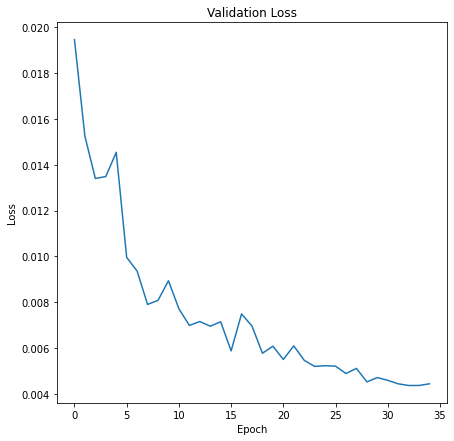

In [6]:
plot_graph(test_losses, "Loss")

## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

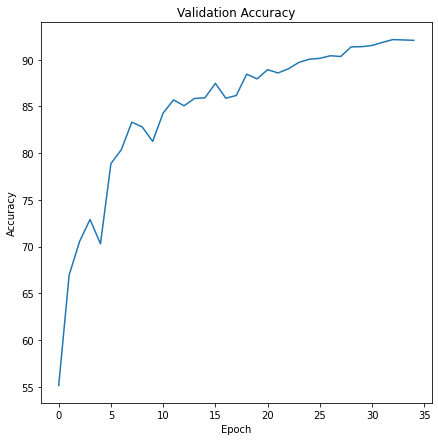

In [7]:
plot_graph(test_accs, "Accuracy")

## Correct Predicted Images

Display 25 correctly classified test images

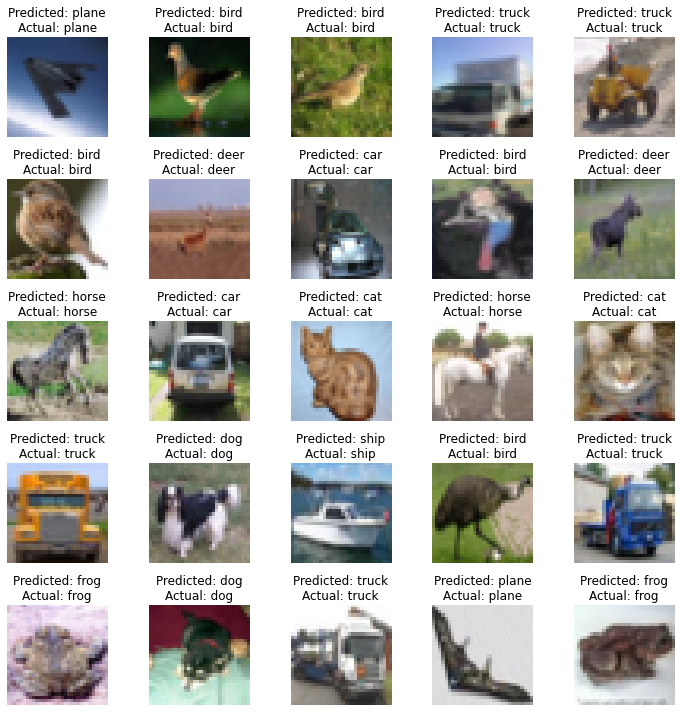

In [8]:
plot_images(correct_imgs, data.classes, "correct_imgs.png")

## Misclassified Images

Display 25 misclassified test images

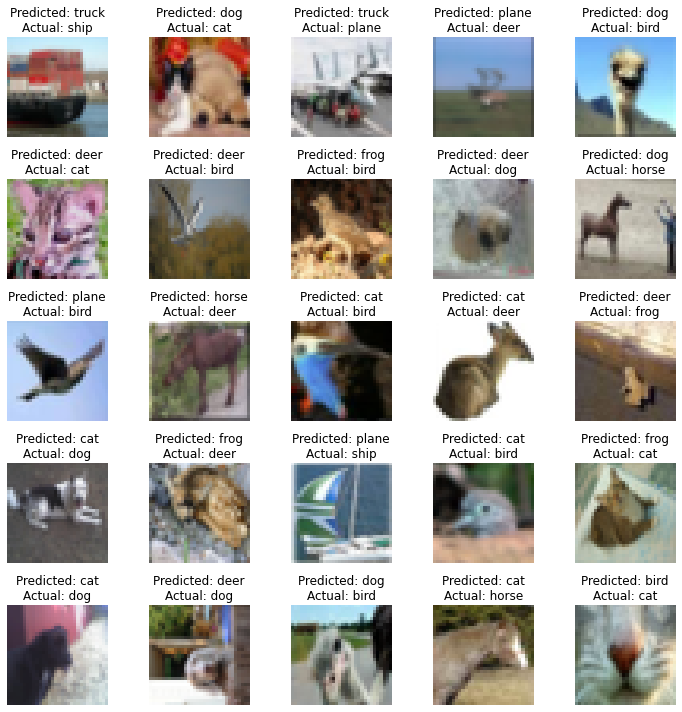

In [9]:
plot_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

## Visualize GradCam

Use GradCam to understand where the network is looking at while prediction

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCam for correctly classified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

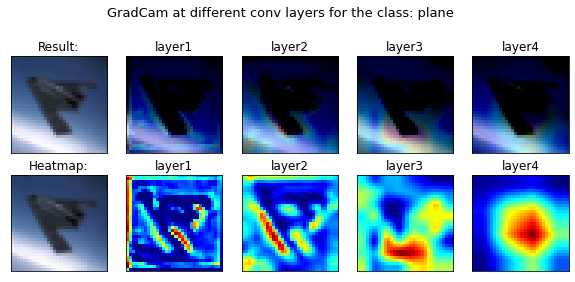

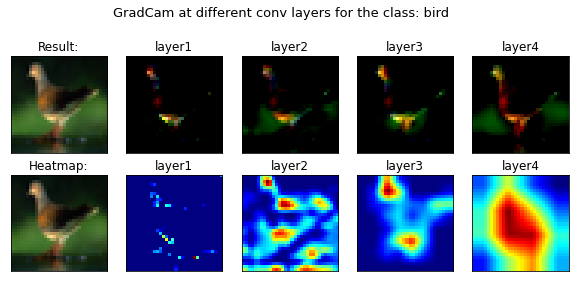

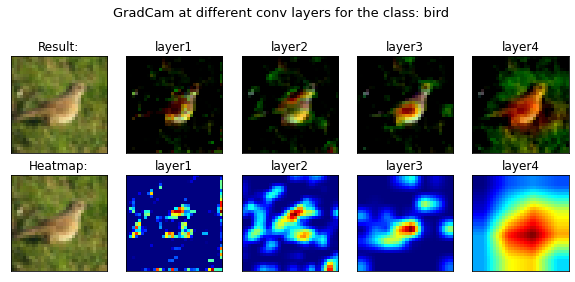

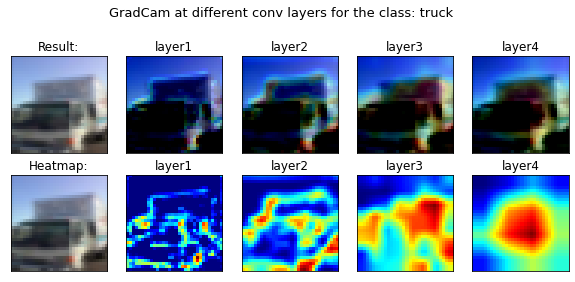

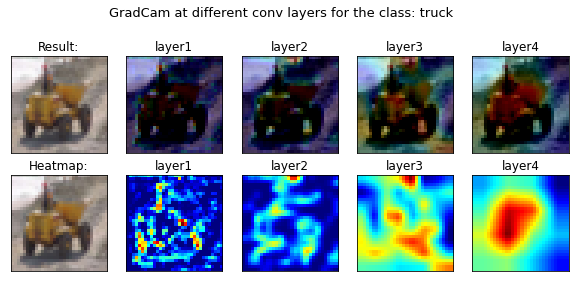

In [11]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

### GradCam for incorrectly classified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

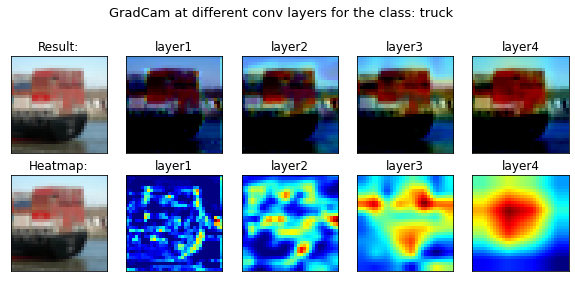

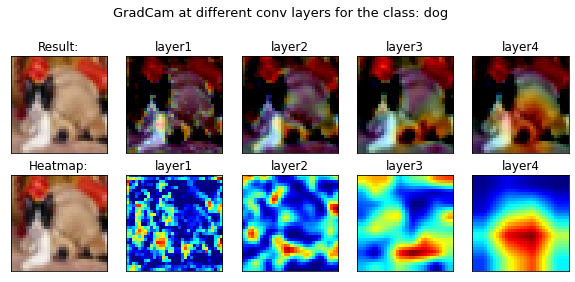

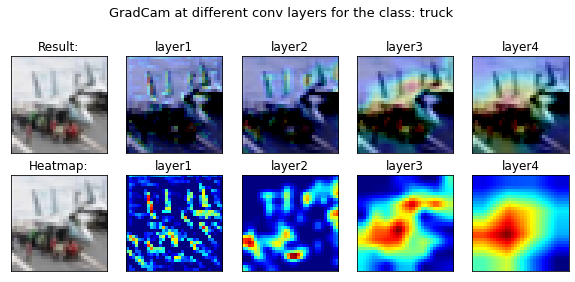

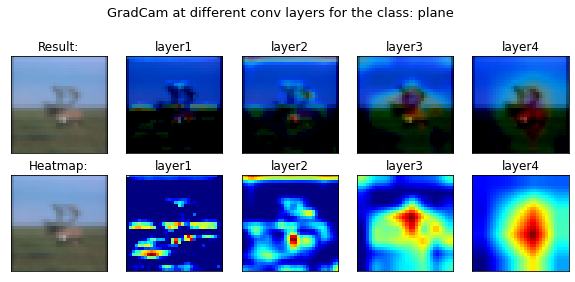

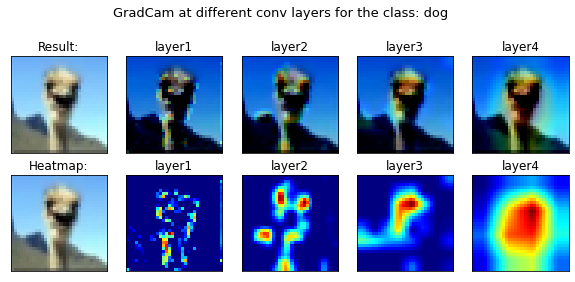

In [12]:
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")